In [1]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
#Get the stock quote 
df = web.DataReader('TSLA', data_source='yahoo', start='2015-01-01', end='2021-01-22') 
#Show the data 
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,44.650002,42.652000,44.574001,43.862000,23822000.0,43.862000
2015-01-05,43.299999,41.431999,42.910000,42.018002,26842500.0,42.018002
2015-01-06,42.840000,40.841999,42.012001,42.256001,31309500.0,42.256001
2015-01-07,42.956001,41.956001,42.669998,42.189999,14842000.0,42.189999
2015-01-08,42.759998,42.001999,42.562000,42.124001,17212500.0,42.124001
...,...,...,...,...,...,...
2021-01-15,859.900024,819.099976,852.000000,826.159973,38647900.0,826.159973
2021-01-19,850.000000,833.000000,837.799988,844.549988,25367000.0,844.549988
2021-01-20,859.500000,837.280029,858.739990,850.450012,25665900.0,850.450012


In [3]:
df.shape

(1525, 6)

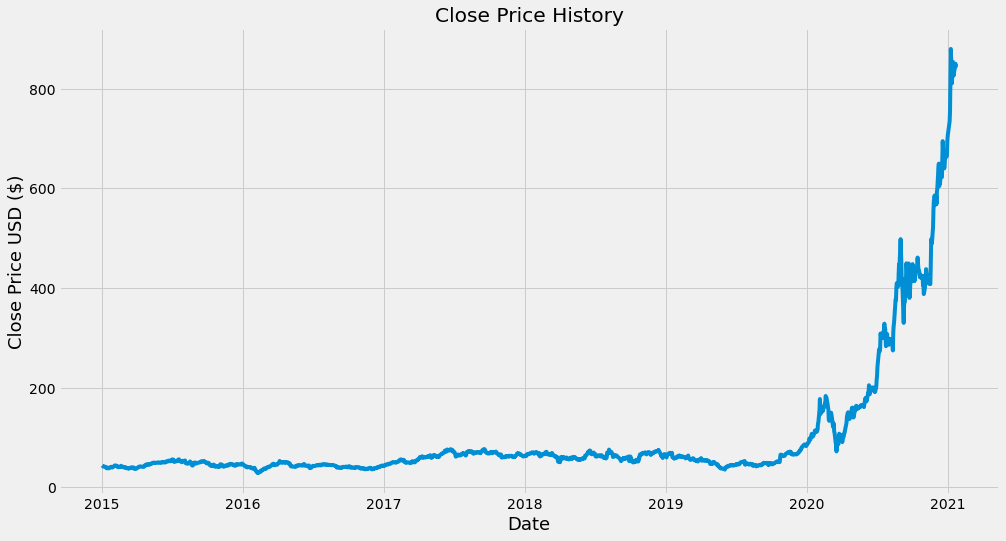

In [4]:
#Visualize the closing price history
plt.figure(figsize=(15,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [5]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])

#Converting the dataframe to a numpy array
dataset = data.values

#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)  # set to contain 80% of data

In [6]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [7]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]

#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [8]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
#Train the model
model.fit(x_train, y_train, batch_size=2, epochs=2)

Epoch 1/2
580/580 [==============================] - 20s 35ms/step - loss: 4.6048e-05
Epoch 2/2
580/580 [==============================] - 22s 38ms/step - loss: 1.7875e-05


In [10]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]

#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] 

for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [11]:
#Convert x_test to a numpy array so that it can test the LTSM model
x_test = np.array(x_test)

#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [12]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions) # Undo scaling

Get the root mean squared error (RMSE), which is a good measure of how accurate the model is. A value of 0 would indicate that the models predicted values match the actual values from the test data set perfectly.

In [13]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions - y_test)**2)))
rmse

28.913168967924648

<ipython-input-14-a6c15c11181b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


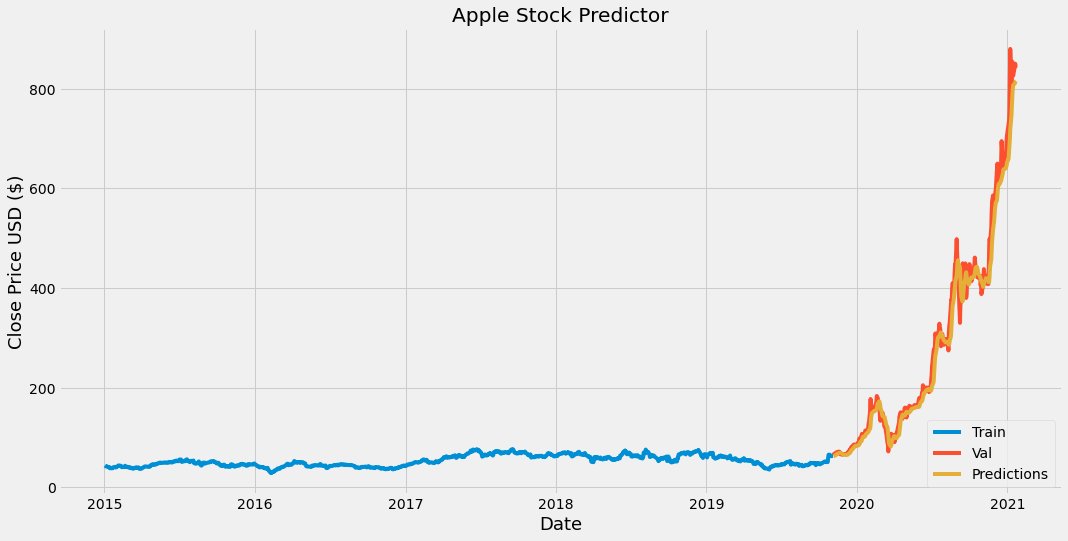

In [14]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Apple Stock Predictor')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [15]:
#Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2019-11-06,65.316002,62.818768
2019-11-07,67.108002,63.010838
2019-11-08,67.428001,63.559406
2019-11-11,69.017998,64.251251
2019-11-12,69.986000,65.159615
...,...,...
2021-01-15,826.159973,807.239807
2021-01-19,844.549988,810.629822
2021-01-20,850.450012,812.905579
